In [1]:
import pandas as pd
import numpy as np
 
dataDir = './data/'

## reading New York City Street Reconstruction 10 Year Plan

the data obtained from [New York City Street Reconstruction 10 Year Plan | NYC Open Data](https://data.cityofnewyork.us/Transportation/New-York-City-Street-Reconstruction-10-Year-Plan/dgm3-gggb)

- Geographic Coordinate Reference: GCS_North_American_1983
- Projection: NAD_1983_StatePlane_New_York_Long_Island_FIPS_3104_Feet


In [3]:
reconstructionsDB = pd.read_csv(dataDir + 'NY_Reconstruction_10_Year_Plan/Intersection/20150716_DOT_Street_Capital_Nodes.csv')
print (reconstructionsDB.shape)
reconstructionsDB.describe()

(2752, 7)


,shapeid,x,y
count,2752.000000,2.752000e+03,2752.000000
mean,1375.500000,1.000664e+06,198677.130814
std,794.578295,2.572146e+04,28784.402169
min,0.000000,9.195150e+05,127478.000000
25%,687.750000,9.887600e+05,180786.500000
50%,1375.500000,9.977505e+05,197971.000000
75%,2063.250000,1.012030e+06,215850.000000
max,2751.000000,1.060451e+06,268476.000000


As we may observe here, the coordinates are not lat/long but something different. We have to convert it.

### Converting coordinates
few related links:
- [Shapefile - Wikipedia](https://en.wikipedia.org/wiki/Shapefile)

- [Prj2EPSG](http://prj2epsg.org/search)

- https://epsg.io/102718 -- this is the projection coordinate system used in the original data


In [4]:
from pyproj import Proj
projstr = """+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 no_defs"""
p = Proj(projstr, preserve_units=True)

def projectCoords(r):
    lon,lat = p(r['x'],r['y'],inverse=True)
    r['x']=lon
    r['y']=lat
   
    return r
    
    
reconstructionsDBt = reconstructionsDB.transform(lambda r: projectCoords(r), axis=1)
del(reconstructionsDB)
reconstructionsDBt.describe()

,shapeid,x,y
count,2752.000000,2752.000000,2752.000000
mean,1375.500000,-73.940756,40.711947
std,794.578295,0.092710,0.079022
min,0.000000,-74.232823,40.516337
25%,687.750000,-73.983736,40.662711
50%,1375.500000,-73.951262,40.710057
75%,2063.250000,-73.899822,40.759045
max,2751.000000,-73.725375,40.903481


Now let's calculate tha bounding box and remove small percent of outliers.

In [6]:
allLat  = np.array(list(reconstructionsDBt['x']))
allLong = np.array(list(reconstructionsDBt['y']))

outlierTreshold=0.1
longLimits = [np.percentile(allLong, outlierTreshold), np.percentile(allLong, 100-outlierTreshold)]
latLimits  = [np.percentile(allLat , outlierTreshold), np.percentile(allLat , 100-outlierTreshold)]
print(longLimits)
print(latLimits)

[40.535430546086531, 40.889727764071715]
[-74.211557192509986, -73.726419436099292]


### Removing outliers
(actuallyit is not necessary)

In [7]:
 
reconstructionsDBt = reconstructionsDBt[(reconstructionsDBt['x']  >= latLimits[0] ) & (reconstructionsDBt['x']  <= latLimits[1]) ]
reconstructionsDBt = reconstructionsDBt[(reconstructionsDBt['y']  >= longLimits[0]) & (reconstructionsDBt['y']  <= longLimits[1])]
reconstructionsDBt = reconstructionsDBt[ pd.notnull(reconstructionsDBt['cons_year'])]
 
print(reconstructionsDBt.shape)
 

(2288, 7)


In [9]:
def filterYear(y, dataset):
    return dataset[ dataset['cons_year'].str.contains(str(y)) ]


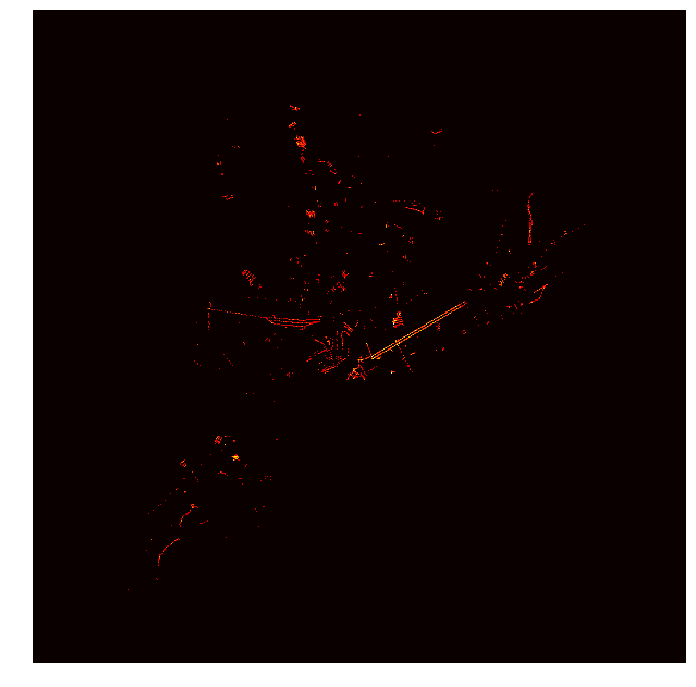

In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

imageSize = (600,600)

longRange = [longLimits[0]-0.1, longLimits[1]+0.1]
latRange = [latLimits[0]-0.1, latLimits[1]+0.1]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

 
locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

 
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='hot')
ax.set_axis_off()

In [11]:
import folium
map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=10,tiles='Stamen Toner')
 
for index, row in filterYear(2017, reconstructionsDBt).iterrows():
    folium.CircleMarker(location=[ row['y'], row['x']], radius=10,
                    popup=''+str(row['cons_year'])+'; '+row['projdesc'], color='#9955cc',
                    fill_color='#9955cc').add_to(map_1)
    
map_1